In [2]:
# Import required libraries
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sns as sns
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [3]:
# Load data
data = pd.read_csv('ETH_USDT__data_1h.csv')
data.dropna(inplace=True)
# data['date'] = pd.to_datetime(data['date'], format='%d-%m-%Y').dt.date
data['date'] = pd.to_datetime(data['open_time'], unit='ms')
data.drop_duplicates(subset='date', keep='first', inplace=True)
df = data[['date', 'close', 'high', 'low']]
df = df.iloc[24 * 60:24 * 180, :]
df.set_index('date', inplace=True)
df.head()

,close,high,low
date,,,
2021-05-31 23:00:00,2706.15,2720.00,2639.20
2021-06-01 00:00:00,2730.67,2740.00,2690.00
2021-06-01 01:00:00,2662.06,2730.67,2656.73
2021-06-01 02:00:00,2644.88,2675.92,2612.63
2021-06-01 03:00:00,2630.79,2679.88,2613.00


In [4]:
from ta.momentum import RSIIndicator, AwesomeOscillatorIndicator
from ta.trend import MACD, ADXIndicator
from ta.volatility import BollingerBands


def add_technical_indicators():
    """
    Add MACD, ADX, RSI, AO, BB to the dataframe
    :return:
    """
    # Create MACD using ta library
    df['macd'] = MACD(close=df['close'], window_slow=26, window_fast=12, window_sign=9).macd()

    # Create ADX using ta library
    df['adx'] = ADXIndicator(high=df['high'], low=df['low'], close=df['close'], window=14).adx()

    # Create upper and lower bollinger bands using ta library
    indicator_bb = BollingerBands(close=df['close'], window=20, window_dev=2)
    # df['upper_bb'] = indicator_bb.bollinger_hband()
    # df['lower_bb'] = indicator_bb.bollinger_lband()
    df['bb_perc'] = indicator_bb.bollinger_pband()  # Percentage band
    df['bb_width'] = indicator_bb.bollinger_wband()  # Width band

    # Create RSI using ta library
    df['rsi'] = RSIIndicator(close=df['close'], window=14).rsi()

    # Create Awesome Osciallator using ta library
    df['ao'] = AwesomeOscillatorIndicator(high=df['high'], low=df['low'], window1=5, window2=34).awesome_oscillator()

In [5]:
# Add technical indicators using the above function
add_technical_indicators()

c:\users\nikhi\pycharmprojects\crypto-trading-bot\venv\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
c:\users\nikhi\pycharmprojects\crypto-trading-bot\venv\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [6]:
# Drop nan values
df = df.dropna()
df.drop(labels=['high', 'low'], inplace=True, axis=1)
df.head()

,close,macd,adx,bb_perc,bb_width,rsi,ao
date,,,,,,,
2021-06-02 08:00:00,2713.71,9.712638,14.093483,1.120491,6.749468,63.592360,35.689706
2021-06-02 09:00:00,2684.51,12.792946,15.141808,0.912257,7.197615,58.232595,48.525647
2021-06-02 10:00:00,2681.16,14.793268,15.895290,0.851686,7.568330,57.632453,61.315029
2021-06-02 11:00:00,2694.35,17.244082,16.231895,0.871008,7.867020,59.406360,69.355059
2021-06-02 12:00:00,2701.10,19.506183,16.820909,0.867012,7.781784,60.321931,74.250294


In [9]:
# We will use past 'p' time steps to predict the future 'q' time steps
p = 4
num_epochs = 100  # These settings are used while training the model
mini_batch_size = 16
dropout = 0.2

# Convert dataframe to numpy array
price_array = df.to_numpy()

In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Preprocess data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = StandardScaler()
price_array = scaler.fit_transform(price_array)
price_array

array([[0.43816419, 0.62615214, 0.1143607 , ..., 0.27022434, 0.70411234,
        0.68030814],
       [0.4252022 , 0.63948664, 0.1313058 , ..., 0.29105004, 0.62897826,
        0.70074626],
       [0.42371512, 0.64814594, 0.14348505, ..., 0.30827745, 0.62056535,
        0.72111025],
       ...,
       [0.49636443, 0.42560448, 0.30216018, ..., 0.21740337, 0.39738778,
        0.50903358],
       [0.49928531, 0.43637949, 0.29897579, ..., 0.19861643, 0.41544333,
        0.51447114],
       [0.50646768, 0.45209237, 0.29021593, ..., 0.18145363, 0.45961522,
        0.51983011]])

In [20]:
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

def make_train_test_data(p_arr, test_size=0.2, shuffle=True):
    """
    This function creates training and testing data from the input array using p and q values provided above.
    :param p_arr:
    :param test_size:
    :param shuffle:
    :return:
    """
    # Make sequences of 100 previous values and take the next value as the target
    time_offset = p
    step = 1
    x_data = []
    y_data = []
    for index in range(time_offset, len(p_arr) - 1, step):
        x_data.append(p_arr[index - time_offset: index, :])
        cpr = p_arr[index - 1, 0]
        npr = p_arr[index, 0]
        y_data.append(npr > cpr)
    x_data = np.array(x_data)
    y_data = np.array(y_data)

    # One hot encode the y_data
    # y_data = to_categorical(y_data)

    # y_data = y_data.reshape((y_data.shape[0], q, 1))

    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(x_data, y_data, test_size=test_size, shuffle=shuffle,
                                                        random_state=42)

    return X_train, Y_train, X_test, Y_test

In [21]:
# Split data into training and test sets using the above function
x_train, y_train, x_test, y_test = make_train_test_data(price_array, test_size=0.2, shuffle=False)
print('Shapes of x_train, x_test, y_train, y_test:', x_train.shape, x_test.shape, y_train.shape, y_test.shape)

Shapes of x_train, x_test, y_train, y_test: (2273, 4, 7) (569, 4, 7) (2273,) (569,)


In [41]:
!pip install seaborn

  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)


You should consider upgrading via the 'C:\Users\nikhi\PycharmProjects\crypto-trading-bot\venv\Scripts\python.exe -m pip install --upgrade pip' command.


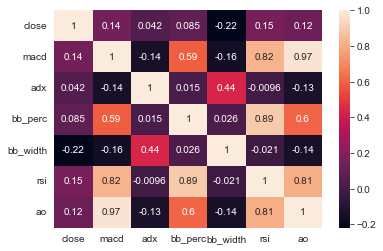

In [8]:
import seaborn as sns

# Visualize the correlation matrix between the features and targets
#df_corr = pd.DataFrame(x_train.squeeze())
#df_corr['target'] = y_train.squeeze()

corr = df.corr()
sns.heatmap(corr, annot=True)

plt.show()

In [22]:
from keras.optimizer_v2.adam import Adam
from keras.layers import Bidirectional, Activation
from dain import Dain

# Create LSTM model
model = Sequential()
# model.add(Dain(dim=x_train.shape[1], n_features=x_train.shape[2]))
model.add(
    Bidirectional(LSTM(units=10, return_sequences=True, activation='relu')))
model.add(Dropout(dropout))
model.add(Bidirectional(LSTM(units=20, return_sequences=True, activation='relu')))
model.add(Dropout(dropout))
model.add(Bidirectional(LSTM(units=10, return_sequences=False, activation='relu')))
model.add(Dense(units=1))
model.add(Activation('sigmoid'))

# Build model with the input shape
model.build(input_shape=(None, x_train.shape[1], x_train.shape[2]))

# create adam optimizer
optimizer = Adam(learning_rate=0.1)

# Compile model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()  # Print model summary

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 4, 20)            1440      
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 4, 20)             0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 4, 40)            6560      
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 4, 40)             0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 20)               4080      
 nal)                                                            
                                                      

In [23]:
# Train model
history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=mini_batch_size, validation_split=0.1)

Epoch 1/100
128/128 [==============================] - 12s 59ms/step - loss: 0.6973 - accuracy: 0.5066 - val_loss: 0.7000 - val_accuracy: 0.5088
Epoch 2/100
128/128 [==============================] - 7s 55ms/step - loss: 0.6975 - accuracy: 0.4797 - val_loss: 0.6938 - val_accuracy: 0.5088
Epoch 3/100
128/128 [==============================] - 7s 54ms/step - loss: 0.6970 - accuracy: 0.5017 - val_loss: 0.6939 - val_accuracy: 0.4912
Epoch 4/100
128/128 [==============================] - 7s 51ms/step - loss: 0.6967 - accuracy: 0.4910 - val_loss: 0.6957 - val_accuracy: 0.4912
Epoch 5/100
128/128 [==============================] - 7s 54ms/step - loss: 0.6951 - accuracy: 0.5022 - val_loss: 0.6965 - val_accuracy: 0.5088
Epoch 6/100
128/128 [==============================] - 7s 54ms/step - loss: 0.6970 - accuracy: 0.5042 - val_loss: 0.6940 - val_accuracy: 0.5088
Epoch 7/100
128/128 [==============================] - 7s 55ms/step - loss: 0.6951 - accuracy: 0.5110 - val_loss: 0.6951 - val_accuracy

KeyboardInterrupt: 

In [125]:
x_test_n = x_test[:, :, :]
y_test_n = y_test[:, :, :]

In [126]:
import math

# Print the predicted and actual values
predicted = model.predict(x_test_n)

count = 0
balance = 500
stake = 100

total_profit = 0
trades = []
balance_history = []
diffs = []
for i in range(len(predicted)):
    cur_price = x_test_n[i, -1, 0]
    if cur_price == 0:
        continue
    p_diff = predicted[i][0] - cur_price
    a_diff = y_test_n[i][0][0] - cur_price
    diffs.append(abs(p_diff) * 100 / cur_price)
    sign = np.sign(p_diff * a_diff)
    if balance >= stake and 1 <= (abs(p_diff) * 100 / cur_price) <= 5:
        balance -= stake
        profit = stake * a_diff / cur_price
        if p_diff < 0:
            profit = -profit
        total_profit += profit
        balance += profit + stake
        stake = 0.2 * balance
        trades.append([cur_price, predicted[i][0], y_test_n[i][0][0], profit, abs(p_diff) * 100 / cur_price])
        balance_history.append(balance)

    if a_diff * p_diff > 0:
        count += 1

print('Accuracy:', count / len(predicted))
print('Balance:', balance)
print('Profit:', total_profit)
trades = np.array(trades)
trades

Accuracy: 0.8910369068541301
Balance: 587.7547477571013
Profit: 87.75474775710079


array([[  0.61104878,   0.6408453 ,   0.62536138,   2.34230149,
          4.87629186],
       [  0.61767984,   0.64062554,   0.60868077,  -1.46374126,
          3.7148196 ],
       [  0.61881131,   0.64044231,   0.6077678 ,  -1.7877687 ,
          3.49557261],
       [  0.61545533,   0.64034128,   0.64419127,   4.66056338,
          4.04350313],
       [  0.61523483,   0.64032561,   0.65001141,   5.69497995,
          4.07824366],
       [  0.61853014,   0.6403327 ,   0.61870435,   0.02869825,
          3.52489906],
       [  0.61885831,   0.64030534,   0.64246044,   3.88608961,
          3.46557982],
       [  0.62117124,   0.64030588,   0.70187918,  13.34006469,
          3.08041301],
       [  0.63365358,   0.64013451,   0.6124087 ,  -3.53180389,
          1.02278833],
       [  0.62507197,   0.64020318,   0.603222  ,  -3.65757373,
          2.42071451],
       [  0.61320934,   0.64026672,   0.66130934,   8.15007805,
          4.41242095],
       [  0.61342455,   0.64066404,   0.657

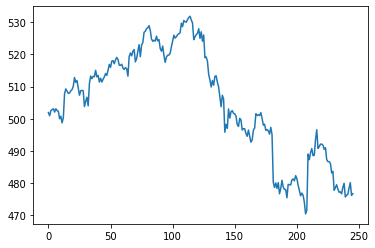

In [20]:
import matplotlib.pyplot as plt

# Plot the balance history
plt.plot(balance_history)
plt.show()

In [21]:
trades[trades[:, 3] < 0]

array([[  0.70210904,   0.71389544,   0.69510261,  -1.00180543,
          1.67871402],
       [  0.71020397,   0.72482139,   0.70304649,  -1.0140915 ,
          2.05819968],
       [  0.71026173,   0.718988  ,   0.70597879,  -0.60678882,
          1.22859935],
       [  0.70597879,   0.71464276,   0.70482808,  -0.16381851,
          1.22722858],
       [  0.69416072,   0.68513727,   0.71039502,  -2.34975066,
          1.29990718],
       [  0.71091483,   0.72293043,   0.69624887,  -2.06630789,
          1.69015984],
       [  0.7491503 ,   0.73591989,   0.75427739,  -0.69711603,
          1.7660549 ],
       [  0.75427739,   0.73775095,   0.75949778,  -0.70401212,
          2.19102944],
       [  0.73370239,   0.72632056,   0.74445861,  -1.50363235,
          1.00610606],
       [  0.71082598,   0.72660226,   0.69423625,  -2.3894524 ,
          2.21942925],
       [  0.69423625,   0.72128958,   0.67936591,  -2.18274937,
          3.8968477 ],
       [  0.68932686,   0.70668799,   0.688